# Food Inspection Project - Milestone #3

### Gil Wassermann, Felix Ruano, Evan Brown

In [171]:
# import libraries
import os
import pandas as pd
import numpy as np
from random import randint, uniform
from datetime import datetime
from urllib import urlretrieve
from zipfile import ZipFile
import geopandas as gpd
from shapely.geometry import Point
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.patches as patches
%matplotlib inline
%matplotlib inline

from __future__ import division

In [5]:
# food inspection database
data_FI = pd.read_csv('datasets/Food_Inspections.csv')

Let us have a quick look at the data.

In [21]:
data_FI.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1967170,"GOOSE ISLAND BAR - T1, B4",GOOSE ISLAND (T1-B4),2477070.0,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,CHICAGO,IL,60666.0,10/25/2016,License,Pass,NaN,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)"
1,1967164,ERMEL'S,ERMEL'S,2484238.0,Restaurant,Risk 1 (High),5729 N NORTHWEST HWY,CHICAGO,IL,60646.0,10/25/2016,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.986001,-87.787528,"(41.98600113711187, -87.78752792018707)"
2,1967146,"WENDY'S PROPERTIES, LLC",WENDY'S,2469194.0,Restaurant,Risk 1 (High),6324 N WESTERN AVE,CHICAGO,IL,60659.0,10/25/2016,License,Pass,NaN,41.996677,-87.689996,"(41.99667685737697, -87.68999575516291)"
3,1967133,LEARN TOGETHER GROW TOGETHER CHILD DEVELOPMENT...,LEARN TOGETHER GROW TOGETHER CHILD DEVELOPMENT C,2384887.0,Daycare Above and Under 2 Years,Risk 1 (High),1126 W 99TH ST,CHICAGO,IL,60643.0,10/25/2016,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.714241,-87.651464,"(41.714240500986136, -87.6514643961654)"
4,1967115,Porkchop,Porkchop,2373923.0,Restaurant,Risk 1 (High),29 E ADAMS ST,CHICAGO,IL,60603.0,10/24/2016,Short Form Complaint,Pass,NaN,41.879397,-87.626631,"(41.87939700209408, -87.62663087278814)"


## Violations and Risk Level

In this portion of the notebook, we will explore the subtleties and apparent implications of the type and number of violations that a restaurant has. We will also investigate the built-in `Risk` and explor how predictive this baseline really is.

### Data Cleaning

The way that the violiations are structured in the dataset provides a slight problem. Firstly, all violations are stored as a single string. Secondly, most violations have comments associated with them. Because of these complications, parsing of the dataset in its raw form is impossible. We will need to clean the data to convert it into an interpretable form.

In [8]:
# cleaned data. will be inputted into DF after cleaning
viol_list_of_lists = []

for i, viol in enumerate(data_FI.Violations):
    # for each establishment
    viols = []
    
    # if nan, no complaints
    if pd.isnull(viol):
        viol_list_of_lists.append(viols)
    else:
        # split into separate complaints
        viols = viol.split(' | ')
        for j, complaint in enumerate(viols):
            complaint = complaint.split(' - Comments: ')[0]
            viols[j] = complaint
        viol_list_of_lists.append(viols)

Let us have a quick look at the form that our violations now take. We will inspect the first five restaurants.

In [9]:
viol_list_of_lists[:5]

[[],
 ['32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED',
  '38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED',
  '43. FOOD (ICE) DISPENSING UTENSILS, WASH CLOTHS PROPERLY STORED',
  '33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
  '35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS',
  '41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING  EQUIPMENT PROPERLY STORED'],
 [],
 ['32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED',
  '33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
  '34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED'],
 []]

To make life even easier, notice that only the number of the violation is important for data analysis purposes. We can incorporate the meaning of the number later in a more qualitative manner. However, for our purposes, we only need the number of the violations.

We will create a `Dict` to sotr these values for later.

In [10]:
violation_code_dict = {}
for lst in viol_list_of_lists:
    for viol in lst:
        code = int(viol.split('. ')[0])
        viol_ = viol.split('. ')[1]
        violation_code_dict[code] = viol_

# all the unique violations
violation_code_dict

{1: 'SOURCE SOUND CONDITION, NO SPOILAGE, FOODS PROPERLY LABELED, SHELLFISH TAGS IN PLACE',
 2: 'FACILITIES TO MAINTAIN PROPER TEMPERATURE',
 3: 'POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE REQUIREMENT DURING STORAGE, PREPARATION DISPLAY AND SERVICE',
 4: 'SOURCE OF CROSS CONTAMINATION CONTROLLED I.E',
 5: 'PERSONNEL WITH INFECTIONS RESTRICTED: NO OPEN SORES, WOUNDS, ETC',
 6: 'HANDS WASHED AND CLEANED, GOOD HYGIENIC PRACTICES; NO BARE HAND CONTACT WITH READY-TO-EAT FOODS.',
 7: 'WASH AND RINSE WATER: CLEAN AND PROPER TEMPERATURE',
 8: 'SANITIZING RINSE FOR EQUIPMENT AND UTENSILS:  CLEAN, PROPER TEMPERATURE, CONCENTRATION, EXPOSURE TIME',
 9: 'WATER SOURCE: SAFE, HOT & COLD UNDER CITY PRESSURE',
 10: 'SEWAGE AND WASTE WATER DISPOSAL, NO BACK SIPHONAGE, CROSS  CONNECTION AND/OR BACK FLOW',
 11: 'ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESIGNED, AND MAINTAINED',
 12: 'HAND WASHING FACILITIES: WITH SOAP AND SANITARY HAND DRYING DEVICES, CONVENIENT AND ACCESSIBLE TO FOOD PREP AREA',
 13:

Now that we have this reference `Dict`, let us update our `viol_list_of_lists`.

In [11]:
# update so that viol_list_of_lists only stores numeric values
for lst in viol_list_of_lists:
    for i, viol in enumerate(lst):
        code = viol.split('. ')[0]
        lst[i] = int(code)

viol_list_of_lists[:5]

[[], [32, 38, 43, 33, 35, 41], [], [32, 33, 34], []]

### Analysis and Visualization

Let us have a look at the distribution of number of violations per restaurant.

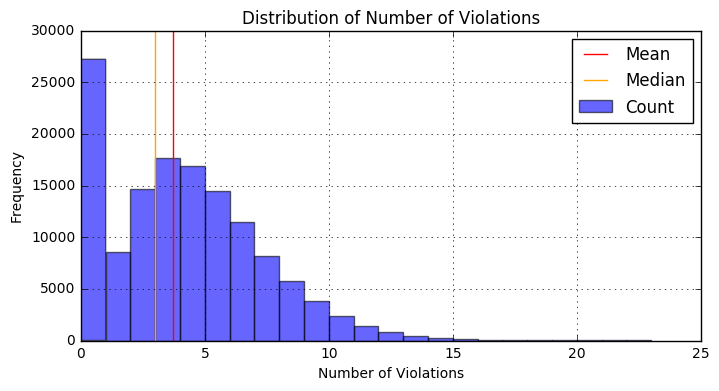

In [12]:
# number of violations per establisment
number_viols = [len(x) for x in viol_list_of_lists]
number_viols_df = pd.Series(data=number_viols, index=data_FI['Inspection ID'], name='Number of Violations')

# visualization
plt.rcParams['figure.figsize'] = (8, 4)
fig, ax = plt.subplots(1, 1)

# each number of violations assigned a bin
ax = number_viols_df.hist(bins=number_viols_df.max(), alpha=0.6, label='Count')
ax.axvline(number_viols_df.mean(), color='red', label='Mean')
ax.axvline(number_viols_df.median(), color='orange', label='Median')
ax.set_title('Distribution of Number of Violations')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Violations')
ax.legend();

As we can see from the distribution, very many restaurants have 0 violations (it is the mode of the distribution) but the majority of the density is around 2 to 5 violations. This could be modeled by a zero-inflated poisson distribution in order to generate confidence intervals.

Now let's have a look at which violations are the most common.

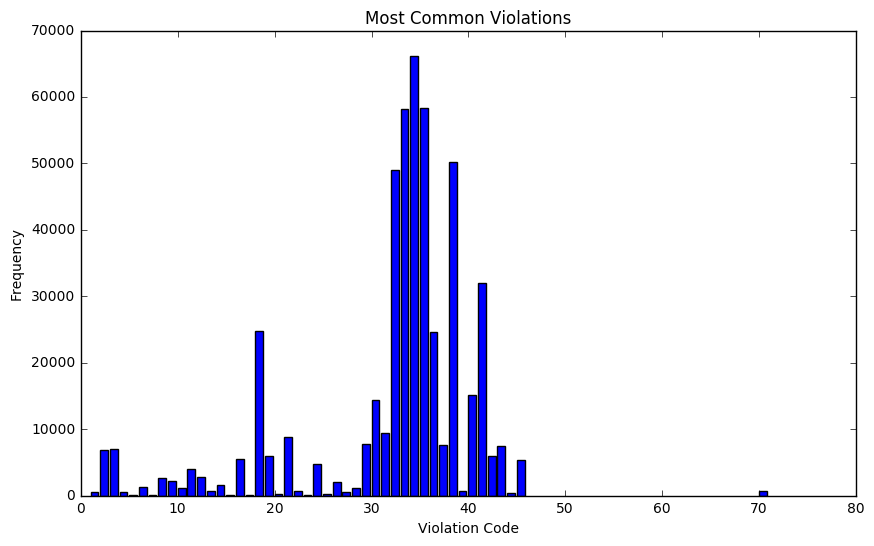

In [18]:
from collections import Counter

# full list of all violations unsorted
violations_ = [item for sublist in viol_list_of_lists for item in sublist]

# count values
counted_violations_dict = Counter(violations_)

# visualization
plt.rcParams['figure.figsize'] = (10, 6)
fig, ax = plt.subplots(1, 1)

# each number of violations assigned a bin
ax.bar(
    counted_violations_dict.keys(),
    counted_violations_dict.values()
)
ax.set_title('Most Common Violations')
ax.set_ylabel('Frequency')
ax.set_xlabel('Violation Code');

So what are these most common violations?

In [119]:
for i, tup in enumerate(counted_violations_dict.most_common()[:5]):
    code, _ = tup
    print '{0}: {1}'.format(i + 1, violation_code_dict[code])

1: FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED
2: WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS
3: FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS
4: VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED
5: FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED


Something to note here that is very interesting is that the most common violations seem to be related to the buildings themselves. We will see if there is a source of building code data and hopefully integrate that in order to test that signal's predictive power in our model.

## Temporal Data (Climate, Season, etc.)

In this section we will explore how violations change over time in order to investigate any possible time dependencies in the data structure.

First we will see if there is any seasonal component to the number of inspections carried out.

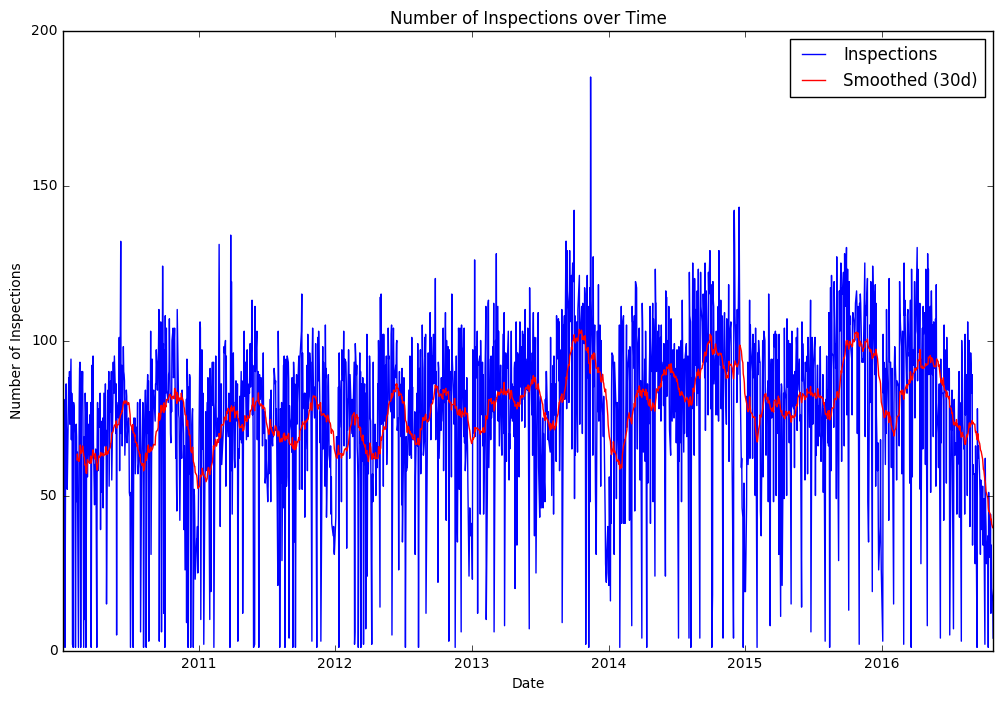

In [28]:
data_FI['Inspection Date'] = pd.to_datetime(data_FI['Inspection Date'], infer_datetime_format=True)
inspections_over_time = data_FI.groupby('Inspection Date').count().loc[:, 'Results']

# smoothed mean
roll = inspections_over_time.rolling(window=30).mean()

# plot results
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(inspections_over_time, label='Inspections')
plt.plot(roll, color='r', label='Smoothed (30d)')
plt.title('Number of Inspections over Time')
plt.xlabel('Date')
plt.ylabel('Number of Inspections')
plt.legend();

As we can see from the graph above, there definitely appears to be a seasonal trend to the data, with peaks and troughs occuring with some degree of regularity. Let us dig into these more by examining the data on a monthly basis.

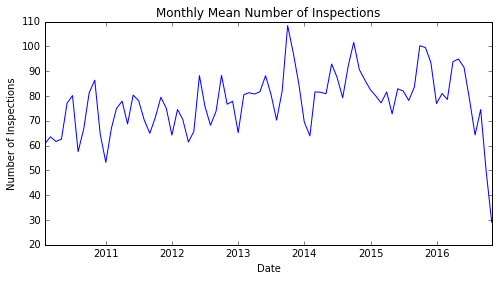

In [317]:
# monthly resample plot
plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(inspections_over_time.resample('M').mean())
plt.title('Monthly Mean Number of Inspections')
plt.ylabel('Number of Inspections')
plt.xlabel('Date');

Here, the seasonality is much more apparent. Another feature that comes out of the data is the steep drop off in number of inpections in 2016. I believe that there are two possible causes for this:

* The quantitative approach to inspections has made food inspection more efficient. Therefore fewer inspections need to be conducted.

* Data has not been processed for more recent dates.

I am inclined to believe that the second of these is the case as the decrease in this number is very drastic indeed. One way we could test this more rigorously is to check the proportion of `Fails` over time. If efficiency really has improved so drastically, we would see an uptick in the proportion of `Fails` as resources are only being allocated to at-risk food establishments. We will do this now:

In [318]:
group_by_date = data_FI.groupby('Inspection Date')

# proportion of fails
prop_fails = []

# loop though groupings
for name, group in group_by_date:
    
    # as long as `Fail` exists
    try:
        fail_count = group.groupby('Results').count().loc[:, 'License #'].loc['Fail']
    except KeyError:
        fail_count = 0
        
    tot_count = group.groupby('Results').count().loc[:, 'License #'].sum()
    prop_fails.append(fail_count / tot_count)

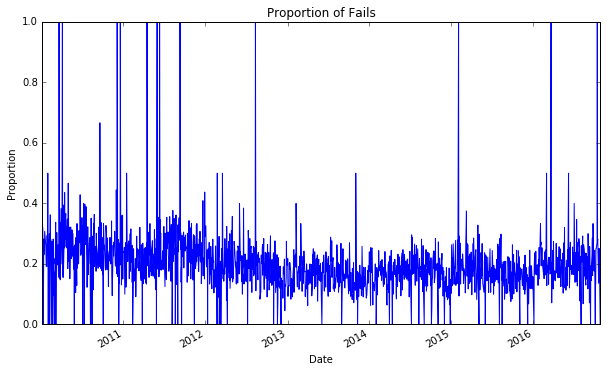

In [319]:
plt.rcParams['figure.figsize'] = (10, 6)
pd.Series(prop_fails, index=inspections_over_time.index).plot()
plt.title('Proportion of Fails')
plt.ylabel('Proportion')
plt.xlabel('Date');

As we can see above, there is no discernable uptick in the proportion of fails. This suggests that the data for 2016 has not been processed yet; therefore, we should remove this data from the fitting of our model as it is not a representative sample of the population.

One transformation that we will use is the fact that there appears to be a little bit of upwards drift in the monthly mean number of inspections. In order to combat this tendency in the model, we will take the first difference of the inspection over time dataset.

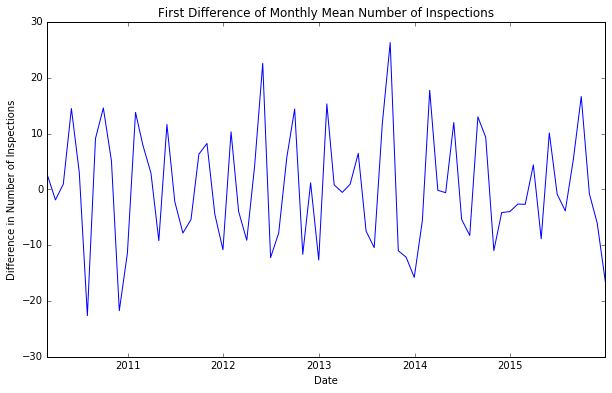

In [320]:
# our transformations of inspections over time
# 1. Truncate to 2016
# 2. Monthly
# 3. 1 lag difference

inspections_over_time= inspections_over_time[inspections_over_time.index < pd.to_datetime('01-01-2016')] \
    .resample('M') \
    .mean()
    
diff_inspections_over_time = inspections_over_time.diff()[1:]

plt.plot(diff_inspections_over_time)
plt.title('First Difference of Monthly Mean Number of Inspections')
plt.ylabel('Difference in Number of Inspections')
plt.xlabel('Date');

Now that we have our time series, let us perform some analysis on the data with a view to fitting an SARIMA model. This is just a normal ARMA model with a differencing term (there appears to be some drift -i.e the process itself is not stationary) and a seasonality component.

We will plot the autocorrelation function and partial autocorrelation function of this data in order to examine intertemporal dependencies.

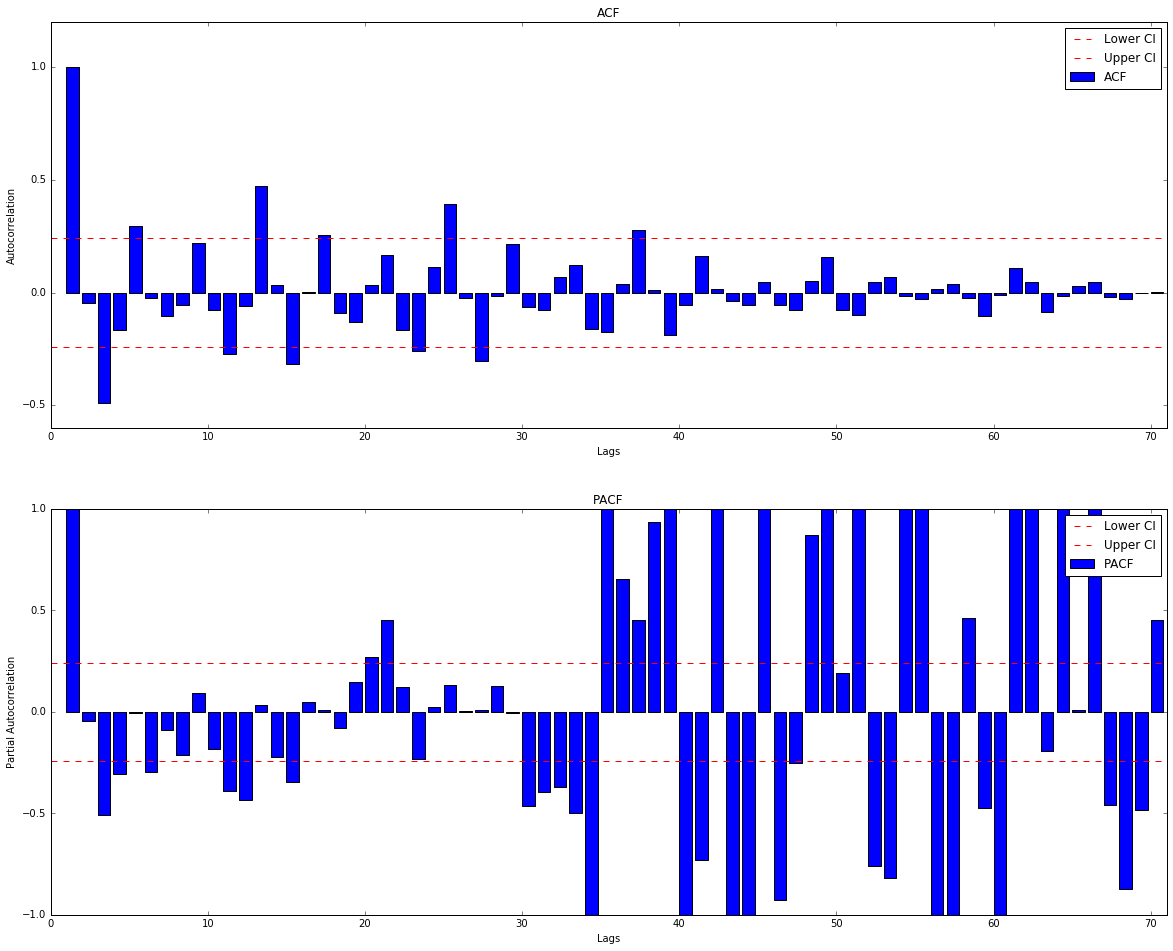

In [321]:
import scipy.stats as stats
import statsmodels.tsa.stattools as stattools

lags = len(diff_inspections_over_time.index)

# white noise process
weak_white_noise_CI = stats.norm.pdf(0.95, loc=0, scale=(np.var(diff_inspections_over_time)/lags)**0.5)

plt.rcParams['figure.figsize'] = (20, 16)
fig, (acf, pacf) = plt.subplots(2, 1)

acf.bar(np.arange(lags) + 1, stattools.acf(diff_inspections_over_time, nlags=lags), label='ACF')
acf.axhline(-weak_white_noise_CI, ls='--', c='r', label='Lower CI')
acf.axhline(weak_white_noise_CI, ls='--', c='r', label='Upper CI')
acf.set_title('ACF')
acf.set_xlabel('Lags')
acf.set_ylabel('Autocorrelation')
acf.set_xlim([0, lags])
acf.legend()

pacf.bar(np.arange(lags) + 1, stattools.pacf(diff_inspections_over_time, nlags=lags)[:-1], label='PACF')
pacf.axhline(-weak_white_noise_CI, ls='--', c='r', label='Lower CI')
pacf.axhline(weak_white_noise_CI, ls='--', c='r', label='Upper CI')
pacf.set_title('PACF')
pacf.set_xlabel('Lags')
pacf.set_ylabel('Partial Autocorrelation')
pacf.set_xlim([0, lags])
pacf.set_ylim([-1, 1])
pacf.legend();

These plots reveal a few interesting facts:

* The ACF function tails off, therefore not an AR model.
* There is a yearly seasonal component to the model (AR bars above white noise band every 6th difference)
* PACF of the first term is very strong (PACF for larger lags is very inaccurate so we will discount this)

Therefore we will try to fit a SARIMA model based on a MA(1) process with a seasonal difference component of 6.

However, there is one slight technical hitch: the SARMIA package in statsmodels is now unavailable in this release, therefore we will fit an ARIMA(6, 1, 1) process. This model is fundamentally flawed as it involves fitting more predictors (6 AR coefficients) as opposed to a single seasonal component for the AR process. The model is therefore more complicated than it should be. 

Let us check the fit of this model.

In [346]:
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(inspections_over_time.astype('float64'), (6, 1, 1)).fit()

C:\Users\wasse\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


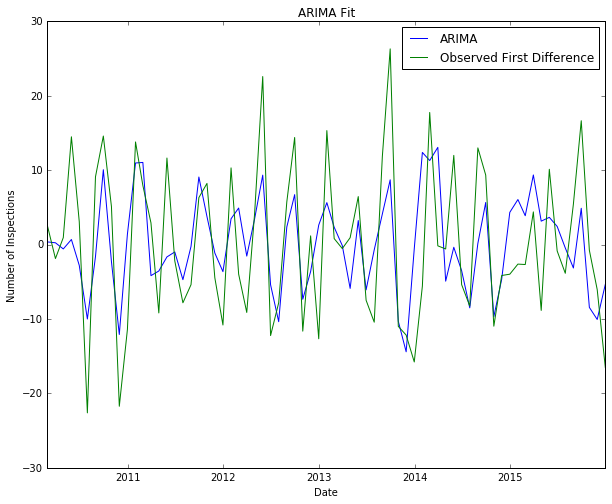

In [347]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.plot(arima_model.predict(), label='ARIMA')
plt.plot(diff_inspections_over_time, label='Observed First Difference')
plt.title('ARIMA Fit')
plt.ylabel('Number of Inspections')
plt.xlabel('Date')
plt.legend();

As we can see above, direction of the ARIMA process appears to be generally correct, but the amplitudes appear to ve a little too extreme. We will check at a later date to see if this temporal component is a useful prediction / forecasting mechanism for the model.

## Inspection Results

In [117]:
inspection_types = data_FI['Inspection Type'].unique()
inspection_types = set([str(l).lower() for l in inspection_types])

In [118]:
data_FI.groupby(data_FI['Inspection Type']).sum()

,Inspection ID,License #,Zip,Latitude,Longitude,Number of Violations
Inspection Type,,,,,,
1315 license reinspection,614488,2.113684e+06,6.060400e+04,4.187801e+01,-8.763319e+01,5
ADDENDUM,634841,1.980406e+06,6.064700e+04,4.192370e+01,-8.769841e+01,0
Business Not Located,176967,1.193504e+06,6.060900e+04,4.182336e+01,-8.767419e+01,0
CANVAS,598256,1.227407e+06,6.060800e+04,4.185040e+01,-8.768050e+01,4
CANVASS,490776,1.716761e+06,6.062200e+04,4.189890e+01,-8.766722e+01,0
CANVASS FOR RIB FEST,98422,4.040000e+02,6.061800e+04,4.195954e+01,-8.768848e+01,3
CANVASS RE INSPECTION OF CLOSE UP,429101,1.991236e+06,6.062500e+04,4.196851e+01,-8.768834e+01,4
CANVASS SCHOOL/SPECIAL EVENT,1118265,2.046680e+06,6.061700e+04,4.169194e+01,-8.753206e+01,1
CANVASS SPECIAL EVENTS,1118288,1.096300e+04,6.061700e+04,4.173582e+01,-8.755125e+01,3


Many of the inspection types are mistyped or barely used. For example, there is only one record of "CANVASS FOR RIB FEST" (passed), and for "TWO PEOPLE ATE AND GOT SICK" (violations). Many inspection strings are also one character off, for example there is a field for "Canvass Special Events" and "Canvass/Special Event". The same holds for 'LICENSE TASK FORCE / NOT -FOR-PROFIT CLU' and 'LICENSE TASK FORCE / NOT -FOR-PROFIT CLUB'. First, lets examine how common different inspection types are. Clearly some values are more common than others, so lets examine which these are. We can at the same time see that a few categories seem to jump out.

In [119]:
data_FI[data_FI['Inspection Type'] == 'TWO PEOPLE ATE AND GOT SICK.'.upper()]['Violations']

88707    19. OUTSIDE GARBAGE WASTE GREASE AND STORAGE A...
Name: Violations, dtype: object

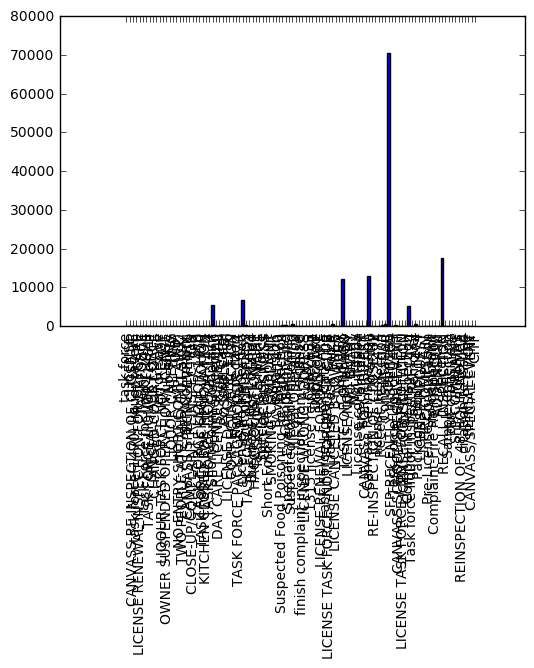

In [120]:
inspection_type_groups = data_FI.groupby(data_FI['Inspection Type']).groups

d = {k: len(v) for k, v in inspection_type_groups.iteritems()}

plt.bar(range(len(d)), d.values(), align='center')
plt.xticks(range(len(d)), d.keys(), rotation = 'vertical')
plt.show()

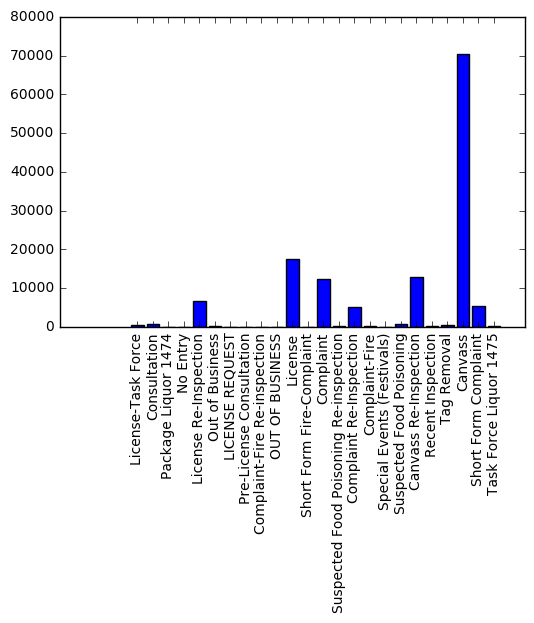

In [121]:
d_most_common = {k: len(v) for k, v in inspection_type_groups.iteritems() if len(v) > 10}

plt.bar(range(len(d_most_common)), d_most_common.values(), align='center')
plt.xticks(range(len(d_most_common)), d_most_common.keys(), rotation = 'vertical')
plt.show()

To simplify matters I broke up the inspection types into 5 main categories: "Canvass", "Complaint", "License", "Task Force", and "Other". Most of the inspection types fell into one of these categories, although it took a little regular expression maneuvering to fit the given types into these five. I then examined how the number of violations differed with respect to each of the 5, to see if there was any visible correlation. 

In [125]:
def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

def list_for_word(word, dic):
    return [k for k in dic.keys() if findWholeWord(word)(k) != None]

task_force_strings = list_for_word("task force", d)
license_strings = list_for_word("license", d)
complaint_strings = list_for_word("complaint", d)
canvass_strings = (list_for_word("canvass", d) + list_for_word("canvas", d))

def simplify_string(x):
    if x in task_force_strings:
        return "Task Force"
    elif x in license_strings:
        return "License"
    elif x in complaint_strings:
        return "Complaint"
    elif x in canvass_strings:
        return "Canvass"
    else:
        return "Other"

In [126]:
canvass_strings

['CANVASS RE INSPECTION OF CLOSE UP',
 'CANVASS SPECIAL EVENTS',
 'CANVASS',
 'CANVASS FOR RIB FEST',
 'Canvass Re-Inspection',
 'Canvass',
 'CANVASS SCHOOL/SPECIAL EVENT',
 'CANVASS/SPECIAL EVENT',
 'CANVAS']

In [135]:
data_FI['Inspection Type'] = data_FI['Inspection Type'].map(simplify_string)
#inspection_type_viol_df = pd.DataFrame([data_FI['Inspection Type'], no_viols_df]).transpose()
#data_FI.merge(no_viols_df.to_frame(), how = 'inner', on = 'Inspection ID')
data_FI['Num Violations'] = number_viols_df.values

In [136]:
inspections_violations_df = pd.concat([data_FI['Inspection Type'], data_FI['Num Violations']], axis=1, keys=['Inspection Type', 'Num Violations'])
inspections_violations_df.groupby('Inspection Type').agg(['mean', 'count'])

Num Violations       
                          mean  count
Inspection Type                      
Canvass               3.721288  83276
Complaint             3.717132  22986
License               3.734769  24292
Other                 3.726498   3638

Inspection Type
Canvass      [[Axes(0.125,0.125;0.775x0.775)]]
Complaint    [[Axes(0.125,0.125;0.775x0.775)]]
License      [[Axes(0.125,0.125;0.775x0.775)]]
Other        [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

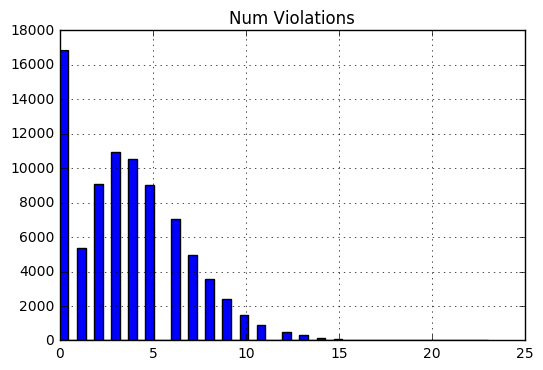

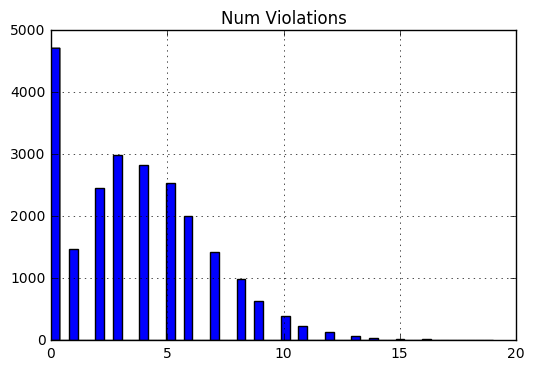

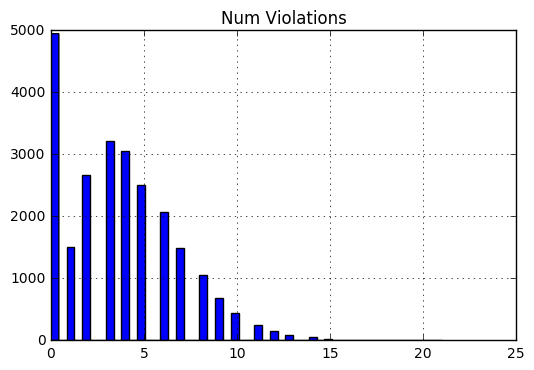

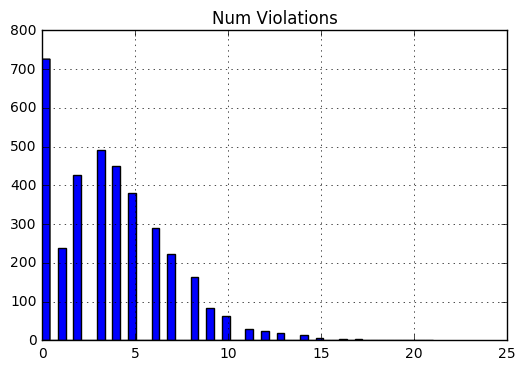

In [137]:
inspections_violations_df.groupby('Inspection Type').hist(bins = 50)

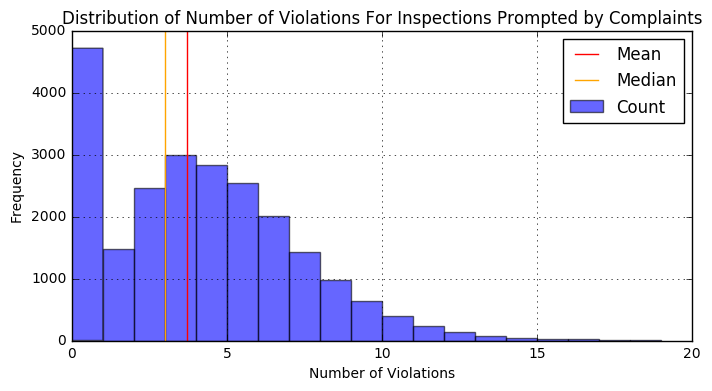

In [138]:
complaints_df = inspections_violations_df[inspections_violations_df['Inspection Type'] == 'Complaint']

# visualization
plt.rcParams['figure.figsize'] = (8, 4)
fig, ax = plt.subplots(1, 1)

# each number of violations assigned a bin
ax = complaints_df['Num Violations'].hist(bins=complaints_df['Num Violations'].max(), alpha=0.6, label='Count')
ax.axvline(complaints_df['Num Violations'].mean(), color='red', label='Mean')
ax.axvline(complaints_df['Num Violations'].median(), color='orange', label='Median')
ax.set_title('Distribution of Number of Violations For Inspections Prompted by Complaints')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Violations')
ax.legend();


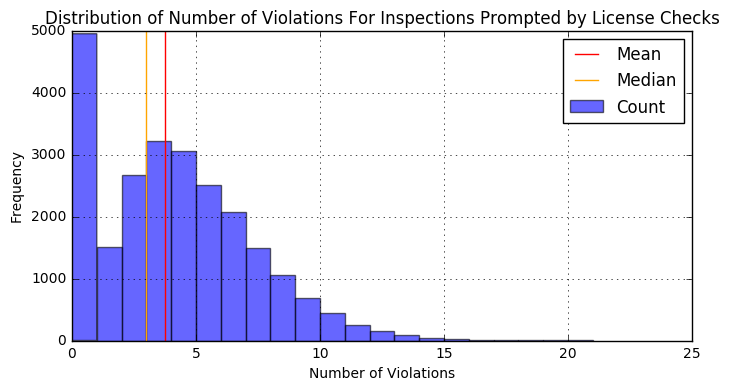

In [139]:
license_df = inspections_violations_df[inspections_violations_df['Inspection Type'] == 'License']

# visualization
plt.rcParams['figure.figsize'] = (8, 4)
fig, ax = plt.subplots(1, 1)

# each number of violations assigned a bin
ax = license_df['Num Violations'].hist(bins=license_df['Num Violations'].max(), alpha=0.6, label='Count')
ax.axvline(license_df['Num Violations'].mean(), color='red', label='Mean')
ax.axvline(license_df['Num Violations'].median(), color='orange', label='Median')
ax.set_title('Distribution of Number of Violations For Inspections Prompted by License Checks')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Violations')
ax.legend();

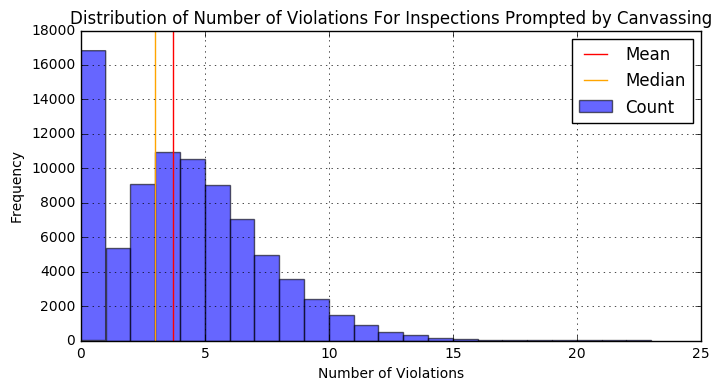

In [140]:
canvass_df = inspections_violations_df[inspections_violations_df['Inspection Type'] == 'Canvass']

# visualization
plt.rcParams['figure.figsize'] = (8, 4)
fig, ax = plt.subplots(1, 1)

# each number of violations assigned a bin
ax = canvass_df['Num Violations'].hist(bins=canvass_df['Num Violations'].max(), alpha=0.6, label='Count')
ax.axvline(canvass_df['Num Violations'].mean(), color='red', label='Mean')
ax.axvline(canvass_df['Num Violations'].median(), color='orange', label='Median')
ax.set_title('Distribution of Number of Violations For Inspections Prompted by Canvassing')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Violations')
ax.legend();

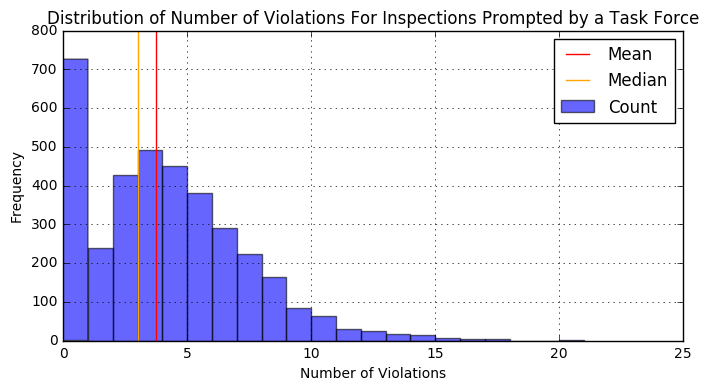

In [150]:
other_df = inspections_violations_df[inspections_violations_df['Inspection Type'] == 'Other']

# visualization
plt.rcParams['figure.figsize'] = (8, 4)
fig, ax = plt.subplots(1, 1)

# each number of violations assigned a bin
ax = other_df['Num Violations'].hist(bins=other_df['Num Violations'].max(), alpha=0.6, label='Count')
ax.axvline(other_df['Num Violations'].mean(), color='red', label='Mean')
ax.axvline(other_df['Num Violations'].median(), color='orange', label='Median')
ax.set_title('Distribution of Number of Violations For Inspections Prompted by a Task Force')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Violations')
ax.legend();

Now we examine the Yelp API to see if we can get anything valuable from it, and cross reference. Ideally we'll be able to cross reference restaurants and see if a restuarant's rating corresponds to the # of violations associated with it. First we'll just make sure the account works, but later on we'lldo more matching of the dataset to yelp results -- to do this we may also have to escape rate limiting issues with querying the API.

Our first step would be to cross-reference the restaurants in the dataset with those in the Yelp database, and add rating as a field to our dataframe. However, we encountered some resistance at first, and need to rethink our strategy.

## Yelp

In [161]:
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator

auth = Oauth1Authenticator(
    consumer_key = 'Oy7XguSi2LNqkezRy9FpLg',
    consumer_secret = 'vCd553h9VA481BjS2aoy_zy5uwM',
    token= 'A1038kcxEgES1ARXf8xpAWHr8y_MUaWo',
    token_secret= 'rqXou8gBHNWYkUcE1_n2d3JAihI'
)

client = Client(auth)

In [162]:
params = {
    'term': 'bar',
    'lang': 'eng'
}

results = client.search('Chicago', **params)

In [163]:
results.businesses[0].name

u'The Zodiac Room'

In [164]:
min_lat, max_lat = data_FI.Latitude.min(), data_FI.Latitude.max()
min_lng, max_lng = data_FI.Longitude.min(), data_FI.Longitude.max()


print "Min Lat:\t" + str(data_FI.Latitude.min())
print "Max Lat:\t" + str(data_FI.Latitude.max())
print "\nMin Lng:\t" + str(data_FI.Longitude.min())
print "Max Lng:\t" + str(data_FI.Longitude.max())

Min Lat:	41.6446701322
Max Lat:	42.0210642478

Min Lng:	-87.9144284393
Max Lng:	-87.525094136


In [165]:
response = client.search_by_bounding_box(
    min_lat,
    min_lng,
    max_lat,
    max_lng,
    **params
)

In [166]:
[r.name for r in response.businesses]

[u'Estereo',
 u'Dos Urban Cantina',
 u'The Library',
 u'The Zodiac Room',
 u"Bernice's Tavern",
 u'Quincy Street Distillery',
 u"Lavergne's Tavern",
 u'Pleasant House Pub',
 u'Skylark',
 u'First Draft',
 u'Scofflaw',
 u'The Barrel',
 u'Three Dots and a Dash',
 u'Del Toro',
 u'Tack Room',
 u'The Den',
 u'Best Intentions',
 u'The Office',
 u"Maria's Packaged Goods and Community Bar",
 u'CH Distillery']

In [167]:
[r.rating for r in response.businesses]

[4.0,
 4.5,
 4.5,
 4.0,
 4.5,
 5.0,
 4.5,
 4.5,
 4.0,
 4.0,
 4.5,
 4.0,
 4.0,
 4.0,
 4.5,
 5.0,
 4.5,
 4.5,
 4.0,
 4.5]

In [168]:
data_FI.loc[0]

Inspection ID                                            1967170
DBA Name                               GOOSE ISLAND BAR - T1, B4
AKA Name                                    GOOSE ISLAND (T1-B4)
License #                                            2.47707e+06
Facility Type                                         Restaurant
Risk                                             Risk 2 (Medium)
Address                                       11601 W TOUHY AVE 
City                                                     CHICAGO
State                                                         IL
Zip                                                        60666
Inspection Date                                       10/25/2016
Inspection Type                                          License
Results                                                     Pass
Violations                                                   NaN
Latitude                                                 42.0085
Longitude                

In [169]:
result = client.search_by_coordinates(42.0085, -87.9144, **params)
[r.name for r in result.businesses]

[u"Barnaby's Family Inn",
 u'Excueses Bar & Billiards',
 u'Korner House Bar & Grill',
 u"Shoeless Joe's Ale House & Grille",
 u"Pap's Ultimate Bar & Grill",
 u'Cafe La Cave',
 u'Lee Street Sports Bar & Games',
 u"Chili's",
 u'Phoenix Bar & Nightclub',
 u'Beacon Tap',
 u'Galileo Bar',
 u'LongHorn Steakhouse',
 u'Restaurant Mehanata',
 u'Billy Goat',
 u'Gaslight Club',
 u'Beaudevin',
 u'USO',
 u'Goose Island Brewing Company',
 u'Bubbles Wine Bar',
 u"Chili's Grill & Bar"]

Interestingly I don't see Goose Island Bar listed here, which is a bit odd. We will examine this API more and brainstorm the best way of integrating it into the dataset and problem.

## Geographical Analysis

In [13]:
data_FI['Number of Violations'] = pd.Series(number_viols, index=data_FI['Inspection ID'].index)

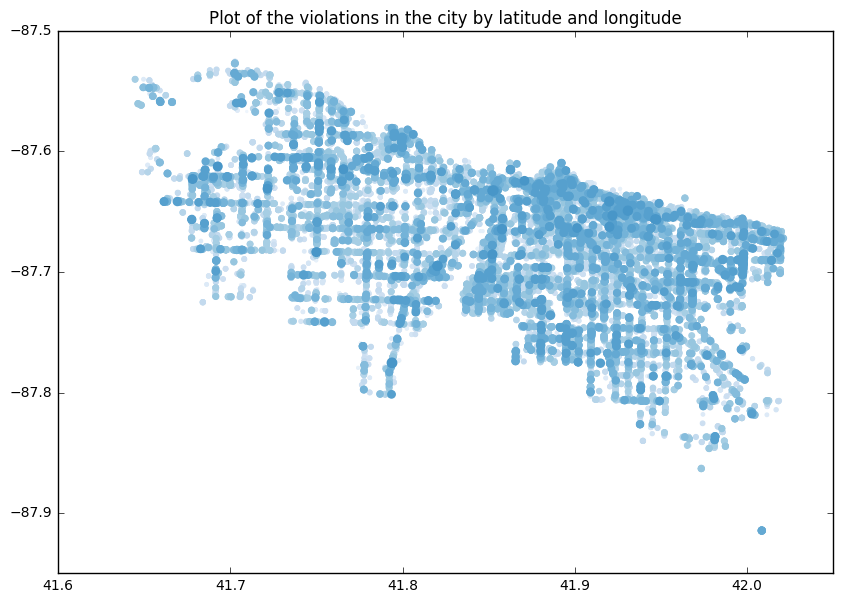

In [61]:
#Sort dataframe by number of violations 
data_FI.sort_values(by='Number of Violations', inplace=True)

#split [0, 1] in to as many parts as there are values for violations
vals = np.linspace(0, 1, np.max(data_FI['Number of Violations'].values) + 1)
#get a color map
c_map = plt.get_cmap('Blues') 
#get a range of colors from color map
c_norm  = colors.Normalize(vmin=0, vmax=1)
#get a map that maps a particular result to a color
number_map = cmx.ScalarMappable(norm=c_norm, cmap=c_map)

#get a color for each results depending on the number of violations
scatter_colors = [number_map.to_rgba(vals[int(violations)]) 
                  for violations in data_FI['Number of Violations'].values]

#get a size for result depending on the number of violations
sizes = data_FI['Number of Violations'].values * 2

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
#plot the dwellings
s = ax.scatter(data_FI['Latitude'].values, data_FI['Longitude'].values, 
           color=scatter_colors, 
           s=sizes)

ax.set_title('Plot of the violations in the city by latitude and longitude')
ax.legend(loc='best')
plt.show()

Analysis of the geospacial data reveals that violations are concentrated within a specific area of the city. The darker points in the chart above show density of violations.

In [28]:
# number of violations per establisment
viols_per_zip = data_FI.groupby(['Zip'])['Number of Violations'].sum().reset_index()

In [87]:
viols_per_zip.sort_values(by='Number of Violations', inplace=True, ascending=False)
viols_per_zip.head(n=10)

,Zip,Number of Violations
46,60614.0,20929
86,60657.0,16762
78,60647.0,16194
54,60622.0,16095
50,60618.0,15730
55,60623.0,15001
57,60625.0,14702
40,60608.0,14212
70,60639.0,13572
64,60632.0,13466


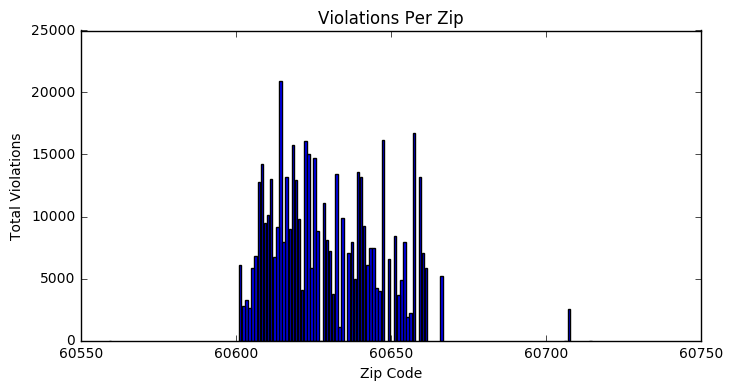

In [63]:
# visualization
plt.rcParams['figure.figsize'] = (8, 4)
fig, ax = plt.subplots(1, 1)

# each number of violations assigned a bin
# each number of violations assigned a bin
ax.bar(
    viols_per_zip['Zip'],
    viols_per_zip['Number of Violations']
)
ax.set_title('Violations Per Zip')
ax.set_ylabel('Total Violations')
ax.set_xlim(60550, 60750)
ax.set_xlabel('Zip Code');

One major takeaway from analysis of the total violations per zip code is the fact that the top 20 zip codes make up the majority of violations in the city. Specifically, the top 18 have more than 10,000 violations per year.